In [165]:
import pandas as pd
# pd.set_option('display.max_rows', 500)
# pd.set_option('display.max_colwidth', 500)
import warnings
import time
warnings.filterwarnings("ignore", category=FutureWarning)

import geopandas as gpd
import shapely
import numpy as np
from functools import partial
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
from matplotlib.ticker import MaxNLocator

import seaborn as sns
from statsmodels.nonparametric.smoothers_lowess import lowess

import nomad.io.base as loader
import nomad.stop_detection.utils as utils
import nomad.stop_detection.hdbscan as HDBSCAN
import nomad.stop_detection.lachesis as LACHESIS
#import nomad.stop_detection.ta_dbscan as TADBSCAN
import nomad.stop_detection.dbscan as TADBSCAN
import nomad.stop_detection.grid_based as GRID_BASED # for oracle visits
import nomad.stop_detection.postprocessing as pp

import nomad.visit_attribution as visits
import nomad.filters as filters
import nomad.city_gen as cg

from nomad.contact_estimation import overlapping_visits, compute_visitation_errors, precision_recall_f1_from_minutes
import pdb

In [ ]:
import nomad.city_gen as cg
city = cg.load('../garden-city.pkl')

def plot_metrics_boxplots(df, metrics,
                          algo_order=None, colors=None,
                          figsize=(24, 5.5), save_path=None):
    # --- normalise inputs -------------------------------------------------
    if algo_order is None:
        # preserve appearance order in the DataFrame
        algo_order = df.algorithm.drop_duplicates().tolist()

    if colors is None:
        cmap = plt.colormaps.get_cmap('tab10')
        colors = {a: cmap(i % cmap.N) for i, a in enumerate(algo_order)}
    else:
        # fill in any missing algorithm colour with the next Tab10 entry
        cmap = plt.colormaps.get_cmap('tab10')
        for i, a in enumerate(algo_order):
            colors.setdefault(a, cmap(i % cmap.N))

    # --- figure -----------------------------------------------------------
    fig, axes = plt.subplots(1, len(metrics), figsize=figsize, sharey=False)

    if len(metrics) == 1:          # when only one metric is passed
        axes = [axes]

    for ax, metric in zip(axes, metrics):
        ax.set_facecolor('#EAEAF2')

        # list of series, one per algorithm
        data = [df.loc[df.algorithm == a, metric].dropna() for a in algo_order]

        bp = ax.boxplot(data,
                        positions=range(len(algo_order)),
                        patch_artist=True,
                        widths=0.4,
                        whis=(5, 95),
                        showfliers=False,
                        medianprops={'color': 'black', 'linewidth': 0.6})

        for box, alg in zip(bp['boxes'], algo_order):
            box.set_facecolor(colors[alg])

        ax.grid(axis='y', color='darkgray', linestyle='--', linewidth=0.8)
        ax.yaxis.set_major_locator(MaxNLocator(nbins=5))
        ax.set_title(metric.replace('_', ' ').title(), fontsize=20)
        ax.set_xticks([])
        ax.tick_params(axis='both', labelsize=18)


    # legend
    handles = [plt.matplotlib.patches.Patch(color=colors[a], label=a)
               for a in algo_order]
    fig.legend(handles, algo_order,
               loc='lower center',
               ncol=len(algo_order),
               bbox_to_anchor=(0.5, -0.015),
               fontsize=18)

    plt.subplots_adjust(bottom=0.1, top=0.95)

    if save_path:
        fig.savefig(f'{save_path}.png', dpi=300)
        fig.savefig(f'{save_path}.svg')

    plt.show()

def classify_building_size_from_id(building_id):
    building = city.buildings.get(building_id)
    n_blocks = len(building.blocks)
    if n_blocks == 1:
        return 'small'
    elif 2 <= n_blocks <= 3:
        return 'medium'
    else:
        return 'big'

def classify_building_type_from_id(building_id):
    building = city.buildings.get(building_id)
    return building.building_type

def classify_dwell(duration):
    if duration < 60:
        return 'low'
    elif 60 <= duration <= 180:
        return 'mid'
    else:
        return 'high'

: 

In [ ]:
traj_cols = {'user_id':'uid', 'x':'x', 'y':'y', 'timestamp':'timestamp'}
poi_table = gpd.read_file('../garden_city.gpkg')

poi_table = poi_table.rename({'type':'building_type'}, axis=1)
poi_table['building_size'] = poi_table['building_id'].apply(classify_building_size_from_id)

diaries_df = loader.from_file("../../nomad/data/diaries", format="parquet", **traj_cols)
diaries_df = diaries_df.rename({'location':'building_id'}, axis=1)
diaries_df = diaries_df.merge(poi_table[['building_id', 'building_size', 'building_type']], on='building_id', how='left')

diaries_df.loc[~diaries_df.building_id.isna(),'dwell_length'] = diaries_df.loc[~diaries_df.building_id.isna(),'duration'].apply(classify_dwell)
diaries_df['building_id'] = diaries_df['building_id']
sparse_df = loader.from_file("../../nomad/data/sparse_traj/", format="parquet", **traj_cols)

: 

## Analyze completeness

In [ ]:
completeness_df = filters.q_stats(sparse_df, traj_cols=traj_cols)

: 

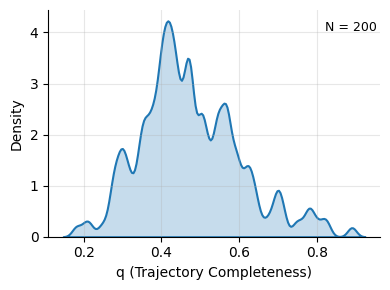

: 

In [ ]:
plt.figure(figsize=(4,3))
ax = sns.kdeplot(
    data=completeness_df,
    x="q_stat",
    fill=True,
    linewidth=1.5,
    bw_adjust=0.25
)

# cosmetics
ax.set_xlabel("q (Trajectory Completeness)")
ax.set_ylabel("Density")
ax.grid(True, alpha=0.3)
sns.despine(top=True, right=True)

# annotation (top-right corner in axes coords)
ax.text(
    0.99, 0.95,
    f"N = {len(completeness_df)}",
    transform=ax.transAxes,
    ha="right",
    va="top",
    fontsize=9
)

plt.tight_layout()
plt.savefig("q_stat_density.svg", format="svg", bbox_inches="tight")
plt.savefig("q_stat_density.png", format="svg", bbox_inches="tight")
plt.show()

## Execution for all users

In [ ]:
## TRANSFORMATION FUNCTIONS
# Use this for steps that should pass a generic DataFrame through
def no_op_df(data, **kwargs):
    return data

# Use this for steps that should pass the 'stops' DataFrame through
def no_op_stops(stops, **kwargs):
    return stops

# Pre-processing snippets
def prejoin_oracle_map(data, diary, **kwargs):
    location = visits.oracle_map(data, diary, timestamp='timestamp', location_id='building_id')
    return data.join(location)

# Post-processing snippets
summarize_stops_with_loc = partial(utils.summarize_stop, x='x', y='y', keep_col_names=False, passthrough_cols=['building_id'], complete_output=True)

def postjoin_poly_map(data, **kwargs):
    # This is a post-labeling step, before stop creation
    location = visits.point_in_polygon(data=data, poi_table=poi_table, method='majority', data_crs='EPSG:3857',
                                       max_distance=12, cluster_label='cluster', location_id='building_id', x='x', y='y')
    return data.join(location)

# Special fix/adjustment snippets
def rem_overlaps_hdbscan(stops, data_with_clusters, params, **kwargs):
    if pp.invalid_stops(stops):
        # The 'pred' data for remove_overlaps is the data with clusters and POI locations joined
        return pp.remove_overlaps(data_with_clusters, **params, dur_min=5, traj_cols=traj_cols, method='cluster', location_id='building_id')
    return stops

def pad_oracle_stops(stops, **kwargs):
    return utils.pad_short_stops(stops, pad=5, dur_min=0, start_timestamp='start_timestamp')

def pad_oracle_stops_long(stops, **kwargs):
    return utils.pad_short_stops(stops, pad=15, dur_min=4, start_timestamp='start_timestamp')

# Each row defines the unique workflow for one algorithm
algo_params = pd.DataFrame([
    {
        'algo': 'ta-hdbscan',
        'func': HDBSCAN.hdbscan_labels,
        'params': {'time_thresh': 240, 'min_pts': 3, 'min_cluster_size': 1, 'include_border_points': True},
        'pre_process_func': no_op_df,             # Correct: Passes 'data'
        'post_labels_func': postjoin_poly_map,
        'special_fix_func': rem_overlaps_hdbscan,
    },
    {
        'algo': 'oracle',
        'func': GRID_BASED.grid_based_labels,
        'params': {'time_thresh': 600, 'min_pts': 0, 'location_id': 'building_id'},
        'pre_process_func': prejoin_oracle_map,
        'post_labels_func': no_op_df,             # Correct: Passes 'data'
        'special_fix_func': pad_oracle_stops_long,
    },
    {
        'algo': 'tadbscan_coarse',
        'func': TADBSCAN._temporal_dbscan_labels,
        'params': {'time_thresh': 240, 'min_pts': 2, 'dist_thresh': 30},
        'pre_process_func': no_op_df,             # Correct
        'post_labels_func': postjoin_poly_map,
        'special_fix_func': rem_overlaps_hdbscan,           # Correct
    },
    {
        'algo': 'tadbscan_fine',
        'func': TADBSCAN._temporal_dbscan_labels,
        'params': {'time_thresh': 120, 'min_pts': 3, 'dist_thresh': 20},
        'pre_process_func': no_op_df,             # Correct
        'post_labels_func': postjoin_poly_map,
        'special_fix_func': rem_overlaps_hdbscan,           # Correct
    },
    {
        'algo': 'lachesis_coarse',
        'func': LACHESIS._lachesis_labels,
        'params': {'dt_max': 240, 'delta_roam': 40},
        'pre_process_func': no_op_df,             # Correct: Passes 'data'
        'post_labels_func': postjoin_poly_map,
        'special_fix_func': no_op_stops,           # Correct: Passes 'stops'
    },
    {
        'algo': 'lachesis_fine',
        'func': LACHESIS._lachesis_labels,
        'params': {'dt_max': 120, 'delta_roam': 25},
        'pre_process_func': no_op_df,             # Correct
        'post_labels_func': postjoin_poly_map,
        'special_fix_func': no_op_stops,           # Correct
    }
])

## METRICS FUNCTIONS
def compute_all_metrics(stops, truth, poi_table, user, algo):
    """
    Calculate all metrics.  One expensive overlap on *raw* stops for
    error rates, a second (gap-filled) overlap for precision/recall.
    """

    stops_err = stops.fillna({'building_id': 'Street'})
    
    overlaps_err = overlapping_visits(
        left=stops_err,
        right=truth.dropna(),
        match_location=False,
        location_id='building_id'
    )

    # 2) PRF overlaps on raw stops (no gap fill at all)
    #    truth we still label Street so they appear in the join step
    stops_prf  = stops.fillna({'building_id': 'Street'})
    truth_prf  = truth.copy().fillna({'building_id': 'Street'})
    
    overlaps_prf = overlapping_visits(
        left=stops_prf,
        right=truth_prf,
        match_location=False,
        location_id='building_id'
    )

    # subset to *matching* POI rows
    prf_overlaps = overlaps_prf[
        overlaps_prf['building_id_left'] == overlaps_prf['building_id_right']
    ]

    # 3) global PRF from minute‐totals
    total_pred  = stops_prf['duration'].sum()
    total_truth = truth_prf['duration'].sum()
    tp          = prf_overlaps['duration'].sum()
    prf1 = precision_recall_f1_from_minutes(total_pred, total_truth, tp)

    # 4) error metrics
    errors = compute_visitation_errors(
        overlaps=overlaps_err,
        true_visits=truth.dropna(),
        location_id='building_id'
    )

    results = [
        {'metric_category': 'general',
         'category_value': 'all',
         'total_pred':total_pred,
         **prf1, **errors}
    ]

    # 5) per-category PRF + error
    for category in ['building_size', 'building_type', 'dwell_length']:
        for val in truth[category].dropna().unique():
            truth_sub = truth[(truth[category] == val)&(truth['building_id']!='Street')]
            # restrict overlaps to any prediction *overlapping* these truth stops
            if category == 'dwell_length':                       # slice by stop itself
                mask_err = overlaps_err['timestamp_right'].isin(truth_sub['timestamp'])
                mask_prf = overlaps_prf['timestamp_right'].isin(truth_sub['timestamp'])
            else:                                                # slice by building
                mask_err = overlaps_err['building_id_right'].isin(truth_sub['building_id'])
                mask_prf = overlaps_prf['building_id_right'].isin(truth_sub['building_id'])


            ov_err = overlaps_err[mask_err]
            ov_prf = overlaps_prf[mask_prf]
            prf_ov = ov_prf[ov_prf['building_id_left'] == ov_prf['building_id_right']]

            # per-category PRF from minutes in these slices
            tp_cat       = prf_ov['duration'].sum()
            pred_cat     = ov_err['duration'].sum()
            truth_cat    = truth_sub['duration'].sum()
            prf1_cat     = precision_recall_f1_from_minutes(pred_cat, truth_cat, tp_cat)

            # per-category error on the same slice of truth

            err_cat = compute_visitation_errors(
                overlaps=ov_err,
                true_visits=truth_sub,
                location_id='building_id'
            )

            results.append({
                'metric_category': category,
                'category_value':   val,
                **prf1_cat, **err_cat
            })

    # tag with user & algo
    for rec in results:
        rec.update({'user': user, 'algorithm': algo})

    return results

: 

### OPTIMIZED LOOP

In [ ]:
results_list = []

for user in tqdm(diaries_df.uid.unique(), desc='Processing users'):
    for _, row in algo_params.iloc.iterrows():
        
        # PRE
        sparse = sparse_df[sparse_df['uid'] == user].copy()
        truth = diaries_df[diaries_df['uid'] == user].copy()
        processed_sparse = row.pre_process_func(data=sparse, diary=truth)
        
        # ALGORITHM
        start_time = time.time()
        labels = row.func(processed_sparse, **row.params, traj_cols=traj_cols)
        execution_time = time.time() - start_time
        
        # POST
        data_with_clusters = processed_sparse.join(labels)
        data_with_locations = row.post_labels_func(data=data_with_clusters)
        stops = data_with_locations[data_with_locations.cluster != -1].groupby('cluster', as_index=False).apply(summarize_stops_with_loc, include_groups=False)
        stops = row.special_fix_func(stops=stops, data_with_clusters=data_with_locations, params=row.params)

        # METRICS
        metrics = compute_all_metrics(stops, truth, poi_table, user, row.algo)

        # Add execution time to the first metric entry (the 'general' one)
        if metrics:
            metrics[0]['execution_time'] = execution_time
        
        results_list.extend(metrics)

results_df = pd.DataFrame(results_list)

print("Processing Complete!")

: 

In [ ]:
try:
    results_df = pd.read_csv("results.csv")
except:
    results_df.to_csv('results.csv', index=False)

: 

In [ ]:
general_metrics_df = results_df[results_df['metric_category'] == 'general'].copy()

: 

In [ ]:
# BOOTSTRAPPING GROUPBY
agg_keys = ['missed_fraction','merged_fraction','split_fraction','precision','recall','f1']
ua = general_metrics_df.groupby(['user','algorithm'], as_index=False)[agg_keys].median()
users = ua['user'].unique()
output = []
for _ in range(2000):
    draw = np.random.choice(users, size=len(users), replace=True)
    bs = ua[ua.user.isin(draw)]
    output.append(bs.groupby('algorithm', as_index=False)[agg_keys].median())
metrics_bootstrap_df = pd.concat(output, ignore_index=True)

: 

In [ ]:
# # For debugging!!!
# metrics = ['missed_fraction', 'merged_fraction', 'split_fraction', 'precision', 'recall', 'f1']
# plot_metrics_boxplots(metrics_bootstrap_df, metrics, algo_order=None, colors=None, save_path=None)

: 

### Plot boostrapped per-stop metrics for general trajectory

In [ ]:
# base colors for coarse versions
shade = lambda c,f=0.6: mcolors.to_hex(tuple(f*x for x in mcolors.to_rgb(c)))
raw = {'oracle':'royalblue','ta-hdbscan':'darkorange','lachesis_coarse':'palevioletred','tadbscan_coarse':'limegreen'}

_base = {k:mcolors.to_hex(mcolors.to_rgb(v)) for k,v in raw.items()}

algo_order = ['oracle','ta-hdbscan','lachesis_coarse','tadbscan_coarse','lachesis_fine', 'tadbscan_fine']
colors = {a:(_base[a] if a in _base else shade(_base[a.split('_')[0]+'_coarse'])) for a in algo_order}

: 

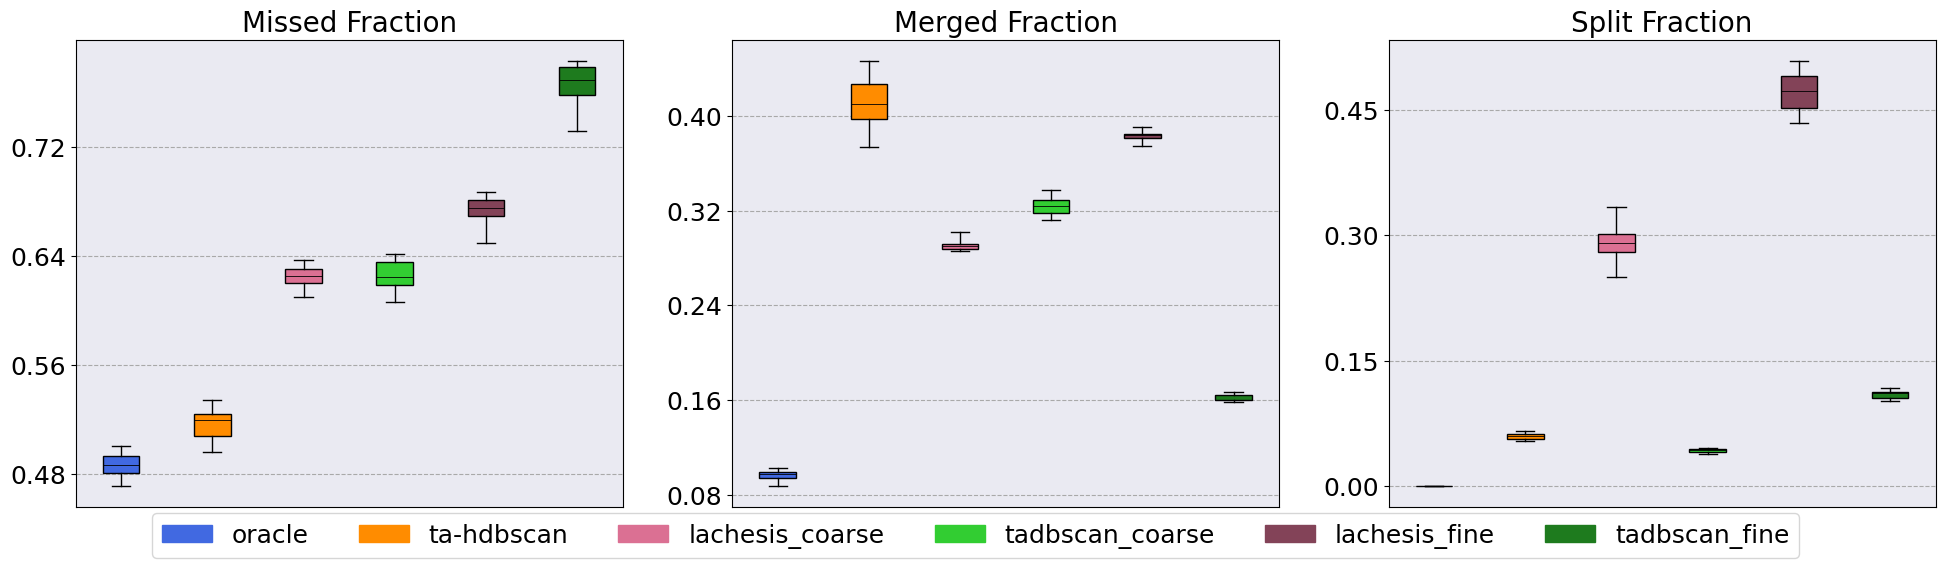

: 

In [ ]:
# metrics = ['missed_fraction', 'merged_fraction', 'split_fraction', 'precision', 'recall', 'f1']
metrics = ['missed_fraction', 'merged_fraction', 'split_fraction']

plot_metrics_boxplots(metrics_bootstrap_df, metrics, algo_order=algo_order, colors=colors, save_path='errors_per_stop')

In [ ]:
# ylabels = {m:f"% {m.split('_')[0]}" for m in ['precision','recall','f1']}
# metrics = ['precision', 'recall', 'f1']
# plot_metrics_boxplots( metrics_bootstrap_df, metrics, algo_order=None, colors=None, save_path='errors_per_stop')

: 

In [ ]:
### Plot pr, rec, f1 per each group in 4 subplots. 

: 

### Plot of F1 scores for each q

In [ ]:
def _compute_core_distance_thresholded(data, time_pairs, times, use_lon_lat, traj_cols, min_pts=3, dist_thresh=100):
    """
    Calculate the core distance for each ping in data, only considering neighbors within dist_thresh.
    
    Parameters
    ----------
    data : dataframe
        Input trajectory data
    time_pairs : list of tuples
        Tuples of timestamps that are close in time given time_thresh
    times : array
        Array of timestamps
    use_lon_lat : bool
        Whether to use geographic coordinates
    traj_cols : dict
        Dictionary of column names
    min_pts : int
        Used to calculate core distance as the distance to the min_pts-th nearest neighbor
    dist_thresh : float
        Maximum distance to consider when calculating neighbors (in meters)
        
    Returns
    -------
    core_distances : dict
        Dictionary mapping timestamps to core distances
    coords : array
        Array of coordinates for each point
    """
    from nomad.stop_detection.hdbscan import _build_neighbor_graph
    
    # Getting coordinates based on whether they are geographic coordinates or cartesian
    if use_lon_lat:
        coords = np.radians(data[[traj_cols['latitude'], traj_cols['longitude']]].values)
    else:
        coords = data[[traj_cols['x'], traj_cols['y']]].values
    
    n = len(coords)
    # Get the index of timestamp in the arrays
    ts_indices = {ts: idx for idx, ts in enumerate(times)}

    # Build neighbor map from time_pairs
    neighbors = _build_neighbor_graph(time_pairs, times)

    D_INF = np.pi * 6_371_000  # max distance on earth
    core_distances = {}

    for i in range(n):
        u = times[i]
        allowed_neighbors = neighbors[u]
        dists = [0.0]  # distance to itself

        for v in allowed_neighbors:
            j = ts_indices.get(v)
            if j is not None:
                if use_lon_lat:
                    dist = utils._haversine_distance(coords[i], coords[j])
                else:
                    dist = np.sqrt(np.sum((coords[i] - coords[j]) ** 2))
                
                # Only add distances within threshold
                # print(dist)
                if dist <= dist_thresh:
                    dists.append(np.round(dist * 4) / 4)

        # pad with large numbers if not enough neighbors
        while len(dists) < min_pts:
            dists.append(D_INF)

        sorted_dists = np.sort(dists)
        core_distances[u] = np.round(sorted_dists[min_pts - 1] * 4)/4
        
    return core_distances, coords


def _compute_density_from_core_distances(data, time_thresh, min_pts, use_lon_lat, traj_cols):
    """Compute average density directly from core distances."""
    from nomad.stop_detection.hdbscan import _find_temp_neighbors, _compute_core_distance
    
    # Get the time column
    if 'timestamp' in traj_cols and traj_cols['timestamp'] in data.columns:
        t_key = 'timestamp'
        use_datetime = False
    elif 'datetime' in traj_cols and traj_cols['datetime'] in data.columns:
        t_key = 'datetime'
        use_datetime = True
    else:
        raise ValueError("Could not find a valid time column")
    
    # Find temporal neighbors
    time_pairs, times = _find_temp_neighbors(data[traj_cols[t_key]], time_thresh, use_datetime)
    
    # Calculate core distances using the existing function
    # core_distances, _ = _compute_core_distance(data, time_pairs, times, use_lon_lat, traj_cols, min_pts)
    core_distances, _ = _compute_core_distance_thresholded(data, time_pairs, times, use_lon_lat, traj_cols, min_pts)
    
    # Filter out infinity values that represent temporally inadmissible points
    finite_distances = [d for d in core_distances.values() if d != float('inf')]
    
    # Calculate density from finite distances only
    if finite_distances:
        median_dist = np.median(finite_distances)
        return 1.0 / median_dist if median_dist > 0 else float('inf')
    else:
        return 0.0

def avg_density_stats(df, time_thresh=240, min_pts=3, traj_cols=None, **kwargs):
    """
    Calculates the average density for each user based on core distances.
    
    For each user, computes the median distance to the min_pts-th nearest neighbor
    for each ping, then returns 1/median as the density value.
    
    Parameters
    ----------
    df : pd.DataFrame
        A DataFrame containing trajectory data.
    time_thresh : int
        Maximum allowed time gap (minutes) for temporal neighbors.
    min_pts : int, optional
        Number of neighbors to consider for core distance, default=2.
    traj_cols : dict, optional
        Dictionary mapping column names.
    **kwargs :
        Additional parameters to specify column names.
        
    Returns
    -------
    pd.DataFrame
        A DataFrame with columns ['user_id', 'avg_density'] for each user.
    """
    import numpy as np
    
    # Parse column names
    traj_cols = loader._parse_traj_cols(df.columns, traj_cols, kwargs)
    
    # Verify required columns exist
    loader._has_time_cols(df.columns, traj_cols)
    loader._has_user_cols(df.columns, traj_cols)
    loader._has_spatial_cols(df.columns, traj_cols)
    
    u_key = traj_cols['user_id']
    
    # Determine which spatial columns to use
    use_lon_lat = 'longitude' in traj_cols and 'latitude' in traj_cols
    
    # Calculate densities using groupby.apply pattern (similar to q_stats)
    densities = df.groupby(u_key).apply(
        lambda group: _compute_density_from_core_distances(
            group, time_thresh, min_pts, use_lon_lat, traj_cols
        )
    ).reset_index(name='avg_density')
    
    # Rename the user column to be consistent
    return densities.rename(columns={u_key: 'user_id'})

: 

In [ ]:
def _find_spatial_neighbors(data, dist_thresh, use_lon_lat, traj_cols):
    """
    Find coordinate pairs that are within a spatial distance threshold.

    Parameters
    ----------
    data : pd.DataFrame
        Input trajectory data.
    dist_thresh : float
        Distance threshold (meters).
    use_lon_lat : bool
        Whether to use geographic coordinates (lon/lat).
    traj_cols : dict
        Mapping for key columns.

    Returns
    -------
    spatial_pairs : list of tuples of timestamps [(t1, t2), ...] that are close in space given dist_thresh.
    times : np.ndarray
        Array of timestamps corresponding to the data.
    """
    times = data[traj_cols['datetime']].values

    if use_lon_lat:
        coords = np.radians(data[[traj_cols['latitude'], traj_cols['longitude']]].values)
    else:
        coords = data[[traj_cols['x'], traj_cols['y']]].values

    n = len(coords)
    # Compute pairwise distances
    if use_lon_lat:
        dist_matrix = np.zeros((n, n))
        for i in range(n):
            for j in range(i+1, n):
                dist = utils._haversine_distance(coords[i], coords[j])
                dist_matrix[i, j] = dist_matrix[j, i] = dist
    else:
        diff = coords[:, np.newaxis, :] - coords[np.newaxis, :, :]
        dist_matrix = np.sqrt(np.sum(diff**2, axis=2))

    # Filter by distance threshold
    within_dist_thresh = np.triu(dist_matrix <= dist_thresh, k=1)
    i_idx, j_idx = np.where(within_dist_thresh)

    spatial_pairs = [(times[i], times[j]) for i, j in zip(i_idx, j_idx)]
    return spatial_pairs, times

def _build_neighbor_graph(time_pairs, times):
    # Build neighbor map from time_pairs
    neighbors = {ts: set() for ts in times}  # TC: O(n)
    for t1, t2 in time_pairs:
        neighbors[t1].add(t2)
        neighbors[t2].add(t1)
    
    return neighbors

def hourly_avg_degree(df, dist_thresh, use_lon_lat, traj_cols):
    """
    For each hour in the trajectory DataFrame, compute the average degree
    of the spatial neighbor graph.

    Parameters
    ----------
    df : pd.DataFrame
        Trajectory data.
    dist_thresh : float
        Distance threshold for spatial neighbors (meters).
    use_lon_lat : bool
        Use geographic coordinates if True.
    traj_cols : dict
        Mapping for key columns.

    Returns
    -------
    pd.DataFrame
        DataFrame with columns ['hour', 'avg_degree'].
    """
    # Ensure timestamp column is in datetime format
    times = pd.to_datetime(df[traj_cols['datetime']])
    df = df.copy()
    df['hour'] = times.dt.floor('H')

    results = []
    for hour, group in df.groupby('hour'):
        spatial_pairs, times_arr = _find_spatial_neighbors(group, dist_thresh, use_lon_lat, traj_cols)
        neighbors = _build_neighbor_graph(spatial_pairs, times_arr)
        degrees = [len(nbrs) for nbrs in neighbors.values()]
        avg_degree = np.mean(degrees) if degrees else 0
        results.append({'hour': hour, 'avg_degree': avg_degree})

    return pd.DataFrame(results)

def avg_degree_stats(df, dist_thresh, use_lon_lat, traj_cols=None, **kwargs):
    """
    Computes the mean of hourly average degrees for each user.

    Parameters
    ----------
    df : pd.DataFrame
        Trajectory data.
    dist_thresh : float
        Distance threshold for spatial neighbors (meters).
    use_lon_lat : bool
        Use geographic coordinates if True.
    traj_cols : dict, optional
        Dictionary mapping column names.
    **kwargs :
        Additional parameters to specify column names.

    Returns
    -------
    pd.DataFrame
        DataFrame with columns ['user_id', 'avg_avg_degree'].
    """
    traj_cols = loader._parse_traj_cols(df.columns, traj_cols, kwargs)
    loader._has_time_cols(df.columns, traj_cols)
    loader._has_user_cols(df.columns, traj_cols)
    u_key = traj_cols['user_id']

    results = []
    for user, group in df.groupby(u_key):
        hourly_degrees = hourly_avg_degree(group, dist_thresh, use_lon_lat, traj_cols)
        avg_avg_degree = hourly_degrees['avg_degree'].mean() if not hourly_degrees.empty else 0
        results.append({'user_id': user, 'avg_avg_degree': avg_avg_degree})

    return pd.DataFrame(results)

: 

In [ ]:
def min_neighbor_distance(df, use_lon_lat, traj_cols):
    """
    For each ping in the trajectory, calculate the distance to its closest neighbor.

    Parameters
    ----------
    df : pd.DataFrame
        Trajectory data.
    use_lon_lat : bool
        Use geographic coordinates if True.
    traj_cols : dict
        Mapping for key columns.

    Returns
    -------
    pd.DataFrame
        DataFrame with columns ['timestamp', 'min_distance'].
    """
    import numpy as np

    times = df[traj_cols['timestamp']].values
    
    if use_lon_lat:
        coords = np.radians(df[[traj_cols['latitude'], traj_cols['longitude']]].values)
        dist_func = lambda a, b: utils._haversine_distance(a, b)
    else:
        coords = df[[traj_cols['x'], traj_cols['y']]].values
        dist_func = lambda a, b: np.sqrt(np.sum((a - b) ** 2))

    n = len(coords)
    min_distances = []
    for i in range(n):
        dists = [dist_func(coords[i], coords[j]) for j in range(n) if i != j]
        min_distance = np.min(dists) if dists else np.nan
        min_distances.append({'timestamp': times[i], 'min_distance': min_distance})

    return pd.DataFrame(min_distances)

def min_neighbor_density_stats(df, use_lon_lat, traj_cols):
    """
    For each user, compute 1/mean(min_distance) from their trajectory.

    Returns
    -------
    pd.DataFrame with columns ['user_id', 'min_neighbor_density']
    """
    results = []
    u_key = traj_cols['user_id']
    for user, group in df.groupby(u_key):
        min_dist_df = min_neighbor_distance(group, use_lon_lat, traj_cols)
        mean_min_dist = np.mean(min_dist_df['min_distance'].dropna())
        # mean_min_dist = mean_min_dist if mean_min_dist < 5 else 5
        density = 1.0 / mean_min_dist if mean_min_dist > 0 else 0.0
        results.append({'user_id': user, 'min_neighbor_density': density})
    return pd.DataFrame(results)

In [169]:
traj_cols = {'user_id':'uid', 'x':'x', 'y':'y', 'timestamp':'timestamp'}

average_min_distance = min_neighbor_density_stats(sparse_df, use_lon_lat=False, traj_cols=traj_cols)

In [170]:
average_min_distance

,user_id,min_neighbor_density
0,admiring_swirles,0.213823
1,admiring_tereshkova,0.277540
2,adoring_almeida,0.200000
3,adoring_chandrasekhar,0.329089
4,adoring_heyrovsky,0.200000
...,...,...
195,youthful_meninsky,0.359293
196,youthful_swanson,0.297087
197,youthful_thompson,0.216833
198,youthful_wilson,0.208974


In [ ]:
average_degree_df = avg_degree_stats(sparse_df, dist_thresh=10, use_lon_lat=False, traj_cols=traj_cols)

: 

In [ ]:
average_degree_df

,user_id,avg_avg_degree
0,admiring_swirles,1.190476
1,admiring_tereshkova,1.303378
2,adoring_almeida,0.907527
3,adoring_chandrasekhar,6.134975
4,adoring_heyrovsky,1.499329
...,...,...
195,youthful_meninsky,7.087632
196,youthful_swanson,3.525304
197,youthful_thompson,1.198420
198,youthful_wilson,1.233663


: 

In [ ]:
average_density_df = avg_density_stats(sparse_df, traj_cols=traj_cols)

/var/folders/nt/0tc5pmb17xd73rr4g1xb0g_00000gn/T/ipykernel_21291/2683337617.py:147: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  densities = df.groupby(u_key).apply(


: 

In [ ]:
average_density_df

,user_id,avg_density
0,admiring_swirles,0.103896
1,admiring_tereshkova,0.129032
2,adoring_almeida,0.101266
3,adoring_chandrasekhar,0.235294
4,adoring_heyrovsky,0.160000
...,...,...
195,youthful_meninsky,0.250000
196,youthful_swanson,0.181818
197,youthful_thompson,0.114286
198,youthful_wilson,0.125000


: 

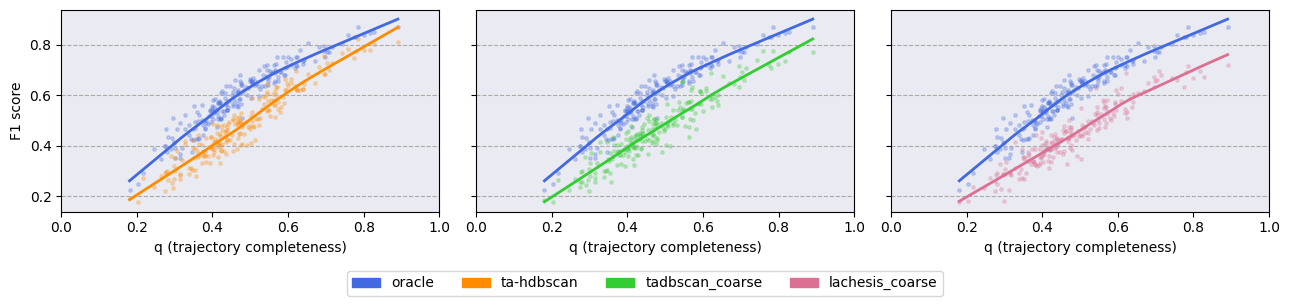

: 

In [ ]:
def plot_f1_vs_q(general_df, completeness_df, save_path=None):
    """Three-panel plot: oracle vs hdbscan / tadbscan_coarse / lachesis_coarse."""

    # --- palette & comparison pairs --------------------------------------
    pairs  = [('oracle', 'ta-hdbscan'),
              ('oracle', 'tadbscan_coarse'),
              ('oracle', 'lachesis_coarse')]

    colors = {'oracle': 'royalblue',
              'ta-hdbscan': 'darkorange',
              'tadbscan_coarse': 'limegreen',
              'lachesis_coarse': 'palevioletred'}

    # --- merge: just rename q_stat -> q ----------------------------------
    comp = completeness_df.rename(columns={'q_stat': 'q'})[['uid', 'q']]
    df   = general_df.merge(comp, left_on='user', right_on='uid', how='left')

    # --- figure ----------------------------------------------------------
    fig, axes = plt.subplots(1, 3, figsize=(13, 2.75), sharey=True)

    for ax, (a1, a2) in zip(axes, pairs):
        ax.set_facecolor('#EAEAF2')            # seaborn-like bg

        for alg in (a1, a2):
            sub = df[df.algorithm == alg].dropna(subset=['q']).sort_values('q')
            if sub.empty:
                continue
            sm  = lowess(sub['f1'], sub['q'], frac=0.6)
            ax.plot(sm[:, 0], sm[:, 1], color=colors[alg], lw=2)
            ax.scatter(sub['q'], sub['f1'], color=colors[alg], s=6, alpha=0.25)

        ax.grid(axis='y', color='darkgray', linestyle='--', lw=0.8)
        ax.yaxis.set_major_locator(MaxNLocator(nbins=5))
        ax.set_xlabel("q (trajectory completeness)")
        ax.set_xticks(np.linspace(0, 1, 6))
        ax.tick_params(axis='both', labelsize=10)

    axes[0].set_ylabel("F1 score")

    # --- single legend ---------------------------------------------------
    handles = [plt.matplotlib.patches.Patch(color=colors[a], label=a) for a in colors]
    fig.legend(handles, colors, loc='lower center',
               ncol=len(colors), bbox_to_anchor=(0.5, -0.12))

    plt.tight_layout()

    if save_path:
        fig.savefig(f"{save_path}.png", dpi=300, bbox_inches='tight')
        fig.savefig(f"{save_path}.svg", bbox_inches='tight')

    plt.show()

plot_f1_vs_q(general_metrics_df, completeness_df,
             save_path="f1_vs_q")

In [ ]:
def plot_f1_vs_density(general_df, average_density_df, save_path=None):
    """Three-panel plot showing F1 score vs density: oracle vs hdbscan / tadbscan_coarse / lachesis_coarse."""

    # --- palette & comparison pairs --------------------------------------
    pairs  = [('oracle', 'ta-hdbscan'),
              ('oracle', 'tadbscan_coarse'),
              ('oracle', 'lachesis_coarse')]

    colors = {'oracle': 'royalblue',
              'ta-hdbscan': 'darkorange',
              'tadbscan_coarse': 'limegreen',
              'lachesis_coarse': 'palevioletred'}

    # --- merge: rename user_id -> uid for consistent joining -------------
    density_df = average_density_df.rename(columns={'user_id': 'uid', 'avg_density': 'density'})
    df = general_df.merge(density_df, left_on='user', right_on='uid', how='left')

    # --- figure ----------------------------------------------------------
    fig, axes = plt.subplots(1, 3, figsize=(13, 2.75), sharey=True)

    for ax, (a1, a2) in zip(axes, pairs):
        ax.set_facecolor('#EAEAF2')            # seaborn-like bg

        for alg in (a1, a2):
            sub = df[df.algorithm == alg].dropna(subset=['density']).sort_values('density')
            if sub.empty:
                continue
            sm  = lowess(sub['f1_as_pct_orac'], sub['density'], frac=0.6)
            ax.plot(sm[:, 0], sm[:, 1], color=colors[alg], lw=2)
            ax.scatter(sub['density'], sub['f1_as_pct_orac'], color=colors[alg], s=6, alpha=0.25)

        ax.grid(axis='y', color='darkgray', linestyle='--', lw=0.8)
        ax.yaxis.set_major_locator(MaxNLocator(nbins=5))
        ax.set_xlabel("Average Density")
        
        # Use log scale for x-axis since density values can vary widely
        ax.set_xscale('log')
        ax.tick_params(axis='both', labelsize=18)

    axes[0].set_ylabel("F1 score as % of Oracle")

    # --- single legend ---------------------------------------------------
    handles = [plt.matplotlib.patches.Patch(color=colors[a], label=a) for a in colors]
    fig.legend(handles, colors, loc='lower center',
               ncol=len(colors), bbox_to_anchor=(0.5, -0.12))

    plt.tight_layout()

    if save_path:
        fig.savefig(f"{save_path}.png", dpi=300, bbox_inches='tight')
        fig.savefig(f"{save_path}.svg", bbox_inches='tight')

    plt.show()

: 

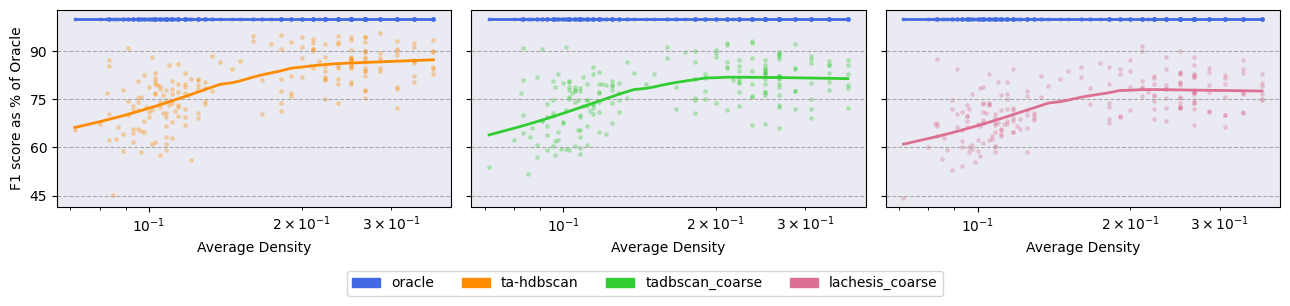

: 

In [ ]:
plot_f1_vs_density(general_metrics_df, average_density_df, 
                   save_path="f1_vs_density")

In [ ]:
def plot_f1_vs_density_single(general_df, average_min_distance, save_path=None):
    """Single panel plot showing F1 score vs density for all algorithm variants."""

    # --- palette & algorithm list ----------------------------------------
    algos = ['ta-hdbscan', 'tadbscan_coarse', 'lachesis_coarse']
    
    # Define base colors
    base_colors = {
        'ta-hdbscan': 'darkorange',
        'tadbscan_coarse': 'limegreen',
        'lachesis_coarse': 'palevioletred'
    }
    
    # Create shaded versions for the fine-tuned variants
    shade = lambda c, f=0.6: mcolors.to_hex(tuple(f*x for x in mcolors.to_rgb(c)))
    colors = {}
    
    for algo in algos:
        if algo in base_colors:
            colors[algo] = base_colors[algo]
        else:
            # For fine variants, use shaded version of corresponding coarse color
            base_algo = algo.split('_')[0] + '_coarse'
            colors[algo] = shade(base_colors[base_algo])

    # --- merge: rename user_id -> uid for consistent joining -------------
    density_df = average_min_distance.rename(columns={'user_id': 'uid', 'min_neighbor_density': 'density'})
    df = general_df.merge(density_df, left_on='user', right_on='uid', how='left')

    # --- figure ----------------------------------------------------------
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.set_facecolor('#EAEAF2')  # seaborn-like bg

    for alg in algos:
        sub = df[df.algorithm == alg].dropna(subset=['density']).sort_values('density')
        if sub.empty:
            continue
        
        sm = lowess(sub['f1_as_pct_orac'], sub['density'], frac=0.6)
        ax.plot(sm[:, 0], sm[:, 1], color=colors[alg], lw=2, label=alg)
        ax.scatter(sub['density'], sub['f1_as_pct_orac'], color=colors[alg], s=6, alpha=0.25)

    ax.grid(axis='y', color='darkgray', linestyle='--', lw=0.8)
    ax.yaxis.set_major_locator(MaxNLocator(nbins=5))
    ax.set_xlabel("Average Density")
    ax.set_ylabel("F1 Score as % of Oracle")
    
    # Use log scale for x-axis since density values can vary widely
    # ax.set_xscale('log')
    ax.tick_params(axis='both', labelsize=10)

    # Create patches for legend
    handles = [plt.matplotlib.patches.Patch(color=colors[a], label=a) for a in algos]
    
    # Add centered legend at bottom
    fig.legend(handles, algos, loc='lower center', 
               ncol=len(algos), bbox_to_anchor=(0.5, -0.12))

    plt.subplots_adjust(bottom=0.2)  # Make room for the legend
    plt.tight_layout()

    if save_path:
        fig.savefig(f"{save_path}.png", dpi=300, bbox_inches='tight')
        fig.savefig(f"{save_path}.svg", bbox_inches='tight')

    plt.show()

: 

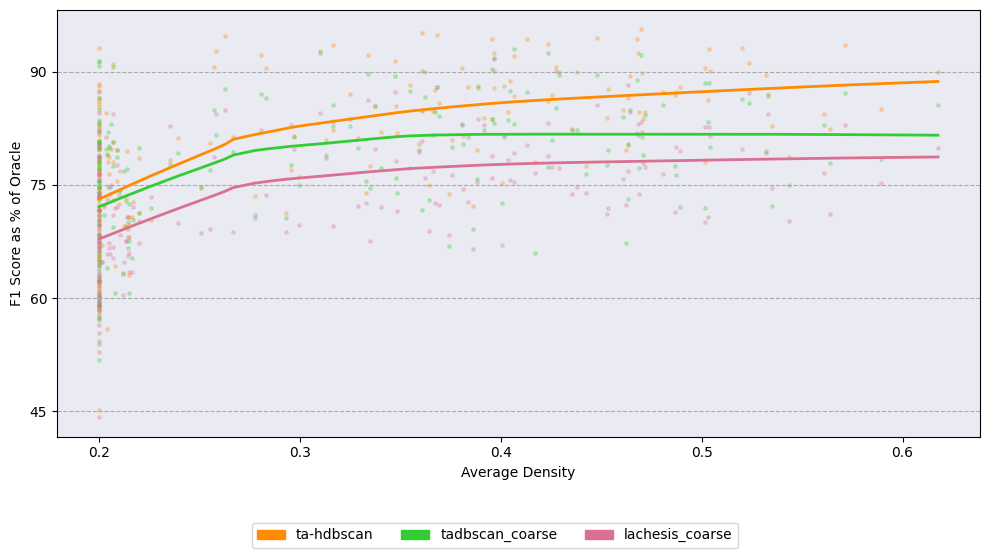

In [171]:
plot_f1_vs_density_single(general_metrics_df, average_min_distance, 
                         save_path="f1_vs_degree_single")

### Metrics for each category value

In [ ]:
# for each user, algo, and category_value
if 'f1_as_pct_orac' not in results_df:
    oracle_df = results_df.loc[results_df.algorithm == 'oracle', ['user', 'category_value','f1']].rename(columns={'f1':'f1_oracle'})
    results_df = results_df.merge(oracle_df, on=['user','category_value'],  how='left')
    results_df['f1_as_pct_orac'] = 100 * results_df['f1'] / results_df['f1_oracle']

: 

In [ ]:
#table_results = results_df.loc[results_df.algorithm.isin(['ta-hdbscan', 'lachesis_coarse','tadbscan_coarse', 'lachesis_fine', 'tadbscan_fine'])]#
table_results = results_df.loc[results_df.algorithm.isin(['ta-hdbscan', 'lachesis_coarse','tadbscan_coarse'])]
table_results = table_results.loc[~table_results.category_value.isin(['all', 'big', 'medium', 'small', 'mid'])]
table_results = table_results.groupby(['metric_category', 'category_value', 'algorithm'], as_index=True)[['f1', 'f1_as_pct_orac']].median().round(2)
table_results.to_csv('results_by_category.csv', index=True)
table_results

f1  f1_as_pct_orac
metric_category category_value algorithm                            
building_type   home           lachesis_coarse  0.50           72.97
                               ta-hdbscan       0.55           81.28
                               tadbscan_coarse  0.53           80.02
                park           lachesis_coarse  0.21           64.83
                               ta-hdbscan       0.24           79.28
                               tadbscan_coarse  0.17           55.97
                retail         lachesis_coarse  0.15           60.14
                               ta-hdbscan       0.15           56.66
                               tadbscan_coarse  0.13           46.15
                work           lachesis_coarse  0.40           80.50
                               ta-hdbscan       0.44           88.42
                               tadbscan_coarse  0.41           81.94
dwell_length    high           lachesis_coarse  0.48           73.91
                               ta-hdbscan       0.53           82.46
                               tadbscan_coarse  0.51           80.57
                low            lachesis_coarse  0.15           58.72
                               ta-hdbscan       0.14           56.46
                               tadbscan_coarse  0.11           43.76

: 

: 